In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

# --- Load Data ---

try:
    # We skip the first two rows which contain header info we don't need for the geometry
    full_df = pd.read_excel('/content/drive/MyDrive/Scientific ML Project/Mid-Term Project/River Dimension Corrected.xlsx', header=2)
except FileNotFoundError:
    print("Error: 'River Dimension Corrected.xlsx' not found.")
    print("Please make sure the CSV file is in the same folder as this script.")
    exit()

# The first 5 columns are stationing data, which we can ignore for the cross-sections.
cs_data_df = full_df.iloc[:, 5:]

#print(cs_data_df.head(10))
#print(len(cs_data_df.columns))

# Store each cross-section's data in a list of DataFrames
cross_sections = []
# The data is in pairs of columns (x, y, empty, x, y, empty...). We iterate in steps of 3.
for i in range(0, len(cs_data_df.columns), 3):
    # Get the column names for the current X and Y pair
    x_col = cs_data_df.columns[i]
    y_col = cs_data_df.columns[i+1]

    if cs_data_df[x_col].notna().any():
        # Create a temporary dataframe for this cross-section
        # and drop rows with missing data (since point counts are inconsistent)
        cs_df = cs_data_df[[x_col, y_col]].dropna()

        # Rename columns to a consistent 'x' and 'y' for easier processing
        cs_df.columns = ['x', 'y']
        cross_sections.append(cs_df)


#Trim Cross section

In [ ]:
import numpy as np
from scipy.signal import savgol_filter

def auto_trim(cs_df, win=5, poly=2,      # Savitzky–Golay 平滑參數（視資料稠密度調整）
              rise_threshold=0.5,  # 必要的“回升量”門檻（相對於最深點的 y 增量）
              flat_slope=0.001,     # 坡度|dy/dx|回到多小，視為“轉平”
              require_flat=True,   # 粗切點是否強制滿足“轉平”條件
              prefer_cross=True):  # 尋找等高切點時，優先“第一次跨越等高線”

    # Data limit: if too short then do not trim
    df = cs_df.sort_values('x').reset_index(drop=True).copy()
    n = len(df)
    if n < 5:
        return df.copy()

    # Smoothen
    w = min(win, n - (1 - n % 2)) # odd number for Savitzky-Golay
    if w % 2 == 0: w -= 1      # if even number minus one to be odd number
    w = max(w, 5)             # the least window should be 5 to not be too sensitive
    y_s = savgol_filter(df['y'].values, window_length=w, polyorder=min(poly, 3))  # smoothen elevation
    dy  = np.gradient(y_s, df['x'].values)  # the slope to find the river bank

    # Deepest Point
    i0 = int(np.argmin(y_s)) # index # of lowest point
    y0 = y_s[i0]       # the rise should be: rise = y - y0

    # The location point that meet both a certain height and certain slope for river bank
    def find_side(i_start, i_end, step):
        i_sel = i_start
        for i in range(i_start, i_end, step):
            cond_rise = (y_s[i] - y0) >= rise_threshold             # force the channel height larger than threshold height
            cond_flat = (abs(dy[i]) <= flat_slope) if require_flat else True
            if cond_rise and cond_flat:
                i_sel = i
                break
        return i_sel

    iL = find_side(i0, -1, -1)  # left from the deepest point i0, i0-1,..., 0
    iR = find_side(i0, n,  +1) # right from the deepest point i0, i0+1, n-1
    if iL == i0 and iR == i0:
        return df

    # Determine the channel height
    rise_L = max(0.0, y_s[iL] - y0)
    rise_R = max(0.0, y_s[iR] - y0)
    rise_common = max(0.0, min(rise_L, rise_R))
    y_cut = y0 + rise_common # the common elevation should be determine for cutting the x location

    # index number for the elevation of y_cut (channel height)
    def find_equal_height_index(side='L'):
        if side == 'L':
            xs = range(i0, -1, -1)
        else:
            xs = range(i0, n, +1)
        prev_i = i0
        for i in xs:
            if prefer_cross:
                # find the first index of the elevation larger than y_cut
                if (y_s[prev_i] <= y_cut and y_s[i] >= y_cut) or (y_s[prev_i] >= y_cut and y_s[i] <= y_cut):
                    return prev_i if abs(y_s[prev_i]-y_cut)<=abs(y_s[i]-y_cut) else i
            prev_i = i

        # if not exceed, than choose the point nearest to the y_cut point
        if side == 'L':
            return np.argmin(np.abs(y_s[:i0+1]-y_cut)) # left to deepent point minus the y_cut determine so that the smaller it get, the closer to the point
        else:
            return np.argmin(np.abs(y_s[i0:]-y_cut))+i0 # for right side

    iL2 = find_equal_height_index('L')
    iR2 = find_equal_height_index('R')
    iL2 = max(0, min(iL2, i0))
    iR2 = min(n-1, max(iR2, i0))

    channel_df = df.iloc[iL2:iR2+1].copy()

    # 把重要資訊也一起 return，方便畫圖時標註
    return channel_df, {
        "iL": iL2,
        "iR": iR2,
        "i0": i0,
        "y_cut": y_cut,
        "y_s": y_s
    }





In [ ]:
def plot_channel(cs_df, channel_df, info, title='Equal height trim', save_path=None):
    plt.figure(figsize=(10,6))
    plt.plot(cs_df['x'], cs_df['y'], 'k--', alpha=0.4, label='Original')
    if not channel_df.empty:
        plt.plot(channel_df['x'], channel_df['y'], 'r-', marker='o', label='Channel-only')

    # Draw reference lines and points
    plt.axhline(y=info['y_cut'], color='b', linestyle=':', label=f'y_cut = {info["y_cut"]:.2f}')
    plt.axvline(x=cs_df['x'][info['iL']], color='g', linestyle='--', label='Left bank')
    plt.axvline(x=cs_df['x'][info['iR']], color='g', linestyle='--', label='Right bank')
    plt.scatter(cs_df['x'][info['i0']], info['y_s'][info['i0']], c='purple', s=80, label='Thalweg')

    plt.title(title)
    plt.xlabel('Cross-stream Distance (m)')
    plt.ylabel('Elevation (m)')
    plt.grid(True)
    plt.legend()

In [ ]:

def view_channel_trim_equal_height(cs_df, channel_df, info, title='Equal height trim', save_path=None):
    plt.figure(figsize=(10,6))
    plt.plot(cs_df['x'], cs_df['y'], 'k--', alpha=0.4, label='Original')
    if not channel_df.empty:
        plt.plot(channel_df['x'], channel_df['y'], 'r-', marker='o', label='Channel-only')

    # Draw reference lines and points
    plt.axhline(y=info['y_cut'], color='b', linestyle=':', label=f'y_cut = {info["y_cut"]:.2f}')
    plt.axvline(x=cs_df['x'][info['iL']], color='g', linestyle='--', label='Left bank')
    plt.axvline(x=cs_df['x'][info['iR']], color='g', linestyle='--', label='Right bank')
    plt.scatter(cs_df['x'][info['i0']], info['y_s'][info['i0']], c='purple', s=80, label='Thalweg')

    plt.title(title)
    plt.xlabel('Cross-stream Distance (m)')
    plt.ylabel('Elevation (m)')
    plt.grid(True)
    plt.legend()

    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved: {save_path}")

    plt.close()  # prevent displaying all figures when looping


             x           y
94   516.84936  158.474664
95   519.16584  157.301184
96   520.62888  156.868368
97   650.22984  156.868368
98   651.81480  157.121352
99   654.34464  157.496256
100  658.42896  158.334456
101  661.01976  158.627064
102  665.07360  158.864808
103  665.31744  158.878463
104  671.71824  159.236664
105  671.80968  159.239712


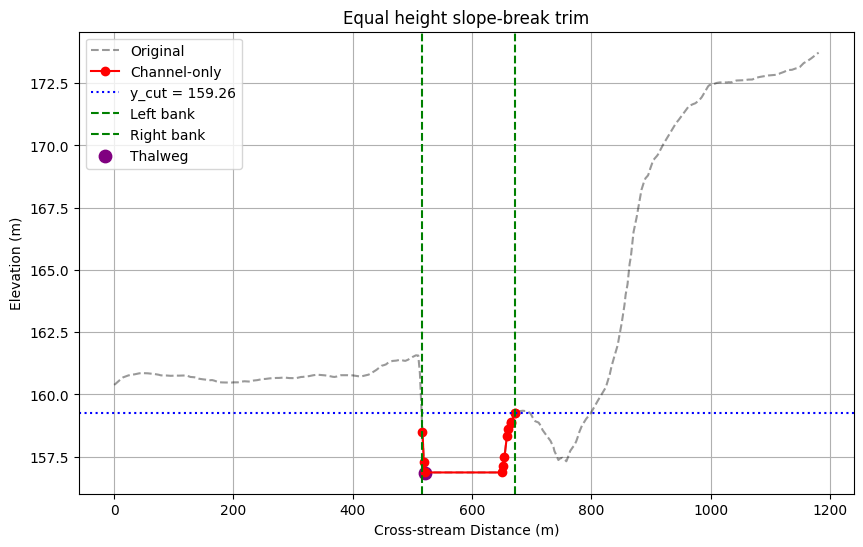

In [ ]:
cs = cross_sections[11]

# 先擷取
channel_eq, info = auto_trim(
    cs,
    win=5, poly=2,
    rise_threshold=0.5,
    flat_slope=0.02,
    require_flat=True,
    prefer_cross=True
)
print(channel_eq)

# 再畫圖
plot_channel(cs, channel_eq, info, title='Equal height slope-break trim')


In [ ]:
def zero_channel_coords(channel_df):
    """
    對剖面資料進行座標歸零處理：
    - x_zeroed：減去最小 x
    - y_zeroed：減去最小 y
    """
    x_min = channel_df['x'].min()
    y_min = channel_df['y'].min()

    channel_df = channel_df.copy()
    channel_df['x_zeroed'] = channel_df['x'] - x_min
    channel_df['y_zeroed'] = channel_df['y'] - y_min

    return channel_df


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
save_dir = '/content/drive/MyDrive/Scientific ML Project/Mid-Term Project/channel_profiles'
for idx, cs in enumerate(cross_sections):
    trimmed, info = auto_trim(cs,
                              win=5, poly=2,
                              rise_threshold=0.5,
                              flat_slope=0.02,
                              require_flat=True,
                              prefer_cross=True)
    zeroed = zero_channel_coords(trimmed)
    filename = f'cs_{idx+1:02d}_trimmed_zeroed.csv'
    zeroed.to_csv(f'{save_dir}/{filename}', index=False)

    print(f"Channel {idx+1} output {filename}")


Channel 1 output cs_01_trimmed_zeroed.csv
Channel 2 output cs_02_trimmed_zeroed.csv
Channel 3 output cs_03_trimmed_zeroed.csv
Channel 4 output cs_04_trimmed_zeroed.csv
Channel 5 output cs_05_trimmed_zeroed.csv
Channel 6 output cs_06_trimmed_zeroed.csv
Channel 7 output cs_07_trimmed_zeroed.csv
Channel 8 output cs_08_trimmed_zeroed.csv
Channel 9 output cs_09_trimmed_zeroed.csv
Channel 10 output cs_10_trimmed_zeroed.csv
Channel 11 output cs_11_trimmed_zeroed.csv
Channel 12 output cs_12_trimmed_zeroed.csv
Channel 13 output cs_13_trimmed_zeroed.csv


In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

save_dir = '/content/drive/MyDrive/Scientific ML Project/Mid-Term Project/channel_profiles'
os.makedirs(save_dir, exist_ok=True)

# Loop through all cross sections
for idx, cs in enumerate(cross_sections):
    # 1. Auto trim to find channel portion
    channel_eq, info = auto_trim(
        cs,
        win=5, poly=2,
        rise_threshold=0.5,
        flat_slope=0.02,
        require_flat=True,
        prefer_cross=True
    )

    # png
    fig_filename = f'cs_{idx+1:02d}_trimmed_plot.png'
    fig_path = os.path.join(save_dir, fig_filename)

    # save
    view_channel_trim_equal_height(cs, channel_eq, info,
                                   title=f'Cross Section {idx+1}',
                                   save_path=fig_path)

    print(f"Saved figure for cross section {idx+1}: {fig_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Figure saved: /content/drive/MyDrive/Scientific ML Project/Mid-Term Project/channel_profiles/cs_01_trimmed_plot.png
Saved figure for cross section 1: /content/drive/MyDrive/Scientific ML Project/Mid-Term Project/channel_profiles/cs_01_trimmed_plot.png
Figure saved: /content/drive/MyDrive/Scientific ML Project/Mid-Term Project/channel_profiles/cs_02_trimmed_plot.png
Saved figure for cross section 2: /content/drive/MyDrive/Scientific ML Project/Mid-Term Project/channel_profiles/cs_02_trimmed_plot.png
Figure saved: /content/drive/MyDrive/Scientific ML Project/Mid-Term Project/channel_profiles/cs_03_trimmed_plot.png
Saved figure for cross section 3: /content/drive/MyDrive/Scientific ML Project/Mid-Term Project/channel_profiles/cs_03_trimmed_plot.png
Figure saved: /content/drive/MyDrive/Scientific ML Project/Mid-Term Project/channel_profiles/cs_04_trimmed_plot.png